In [6]:
!pip install sentence_transformers

  Obtaining dependency information for sentence_transformers from https://files.pythonhosted.org/packages/ba/20/7ef81df2e07322d95332d07c1c38c597f543c1f666d689a3153ba6fa09e3/sentence_transformers-2.6.1-py3-none-any.whl.metadata
  Obtaining dependency information for torch>=1.11.0 from https://files.pythonhosted.org/packages/5c/01/5ab75f138bf32d7a69df61e4997e24eccad87cc009f5fb7e2a31af8a4036/torch-2.2.2-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for typing-extensions>=3.7.4.3 from https://files.pythonhosted.org/packages/01/f3/936e209267d6ef7510322191003885de524fc48d1b43269810cd589ceaf5/typing_extensions-4.11.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/163.3 kB ? eta -:--:--
   ---------------------------------------- 163.3/163.3 kB 9.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/198.6 MB ? eta -:--:--
   ---------------------------------------- 0.6/198.6 MB 19.8 MB/s eta 0:00:10
   ----------------------------

In [58]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
# import cohere
import numpy as np
from rouge import Rouge
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')

In [10]:
def fetch_embedding(texts, embedding_model = "embed-english-v3.0", embedding_type = "clustering"):
    results =  co.embed(
            texts=texts,
            model=COHERE_EMBEDDING_MODEL,
            input_type=embedding_type
        ).embeddings
    return results

def get_rouge(predictions, references):
    rouge = Rouge()
    return rouge.get_scores(predictions, references, avg=True)

In [11]:
# read data
train_df = pd.read_csv("cnn_dailymail/train.csv")
test_df = pd.read_csv("cnn_dailymail/test.csv")
val_df = pd.read_csv("cnn_dailymail/validation.csv")

In [12]:
train_df.head()

,id,article,highlights
0,0001d1afc246a7964130f43ae940af6bc6c57f01,By . Associated Press . PUBLISHED: . 14:11 EST...,"Bishop John Folda, of North Dakota, is taking ..."
1,0002095e55fcbd3a2f366d9bf92a95433dc305ef,(CNN) -- Ralph Mata was an internal affairs li...,Criminal complaint: Cop used his role to help ...
2,00027e965c8264c35cc1bc55556db388da82b07f,A drunk driver who killed a young woman in a h...,"Craig Eccleston-Todd, 27, had drunk at least t..."
3,0002c17436637c4fe1837c935c04de47adb18e9a,(CNN) -- With a breezy sweep of his pen Presid...,Nina dos Santos says Europe must be ready to a...
4,0003ad6ef0c37534f80b55b4235108024b407f0b,Fleetwood are the only team still to have a 10...,Fleetwood top of League One after 2-0 win at S...


In [13]:
train_articles = train_df['article']
train_highlights = train_df['highlights']
test_articles = test_df['article']
test_highlights = test_df['highlights']

In [15]:
article_len = []
for article in tqdm(test_articles):
    token = word_tokenize(article)
    article_len.append(len(token))

100%|██████████| 11490/11490 [00:29<00:00, 393.32it/s]


In [16]:
highlight_len = []
for highlight in tqdm(test_highlights):
    token = word_tokenize(highlight)
    highlight_len.append(len(token))

100%|██████████| 11490/11490 [00:02<00:00, 4068.67it/s]


In [55]:
rouge1 = []
rouge2 = []
rougel = []
error = []

In [56]:
for indx in tqdm(range(len(test_articles))):
    article = test_articles[indx]
    sentence = sent_tokenize(article)
    sent_len = len(sentence)
    
    # sent_embeddings = fetch_embedding(sentence)
    # sent_embeddings = np.array(sent_embeddings)
    sent_embeddings = sbert_model.encode(sentence)
    # sent_embeddings = model.encode(sentence)
    sim_matrix = np.zeros([sent_len, sent_len])
    
    for i in range(sent_len):
        for j in range(sent_len):
            sim_matrix[i][j] = cosine_similarity(sent_embeddings[i].reshape(1,-1), sent_embeddings[j].reshape(1,-1))[0][0]
    
    G = nx.from_numpy_array(sim_matrix)
    
    try:
        pr_scores = nx.pagerank(G, max_iter=200)
    except:
        error.append(indx)
        continue
    
    dict = {sentence[i]:pr_scores[i] for i in range(sent_len)}
    
    sorted_res = np.array(sorted(dict.items(), key=lambda x: x[1], reverse=True))
    
    rouge_score = get_rouge('\n'.join(sorted_res[:3,0]), test_highlights[indx])
    
    rouge1.append(rouge_score['rouge-1']['f'])
    rouge2.append(rouge_score['rouge-2']['f'])
    rougel.append(rouge_score['rouge-l']['f'])

100%|██████████| 11490/11490 [2:53:57<00:00,  1.10it/s] 


In [57]:
len(error)

71

In [60]:
sum(rouge1) / len(rouge1)

0.284955530207277

In [83]:
sum(rouge2) / len(rouge2)

0.09213053336551223

In [84]:
sum(rougel) / len(rougel)

0.2592189875777899

In [66]:
for i in error[::-1]:
    article_len.pop(i)
    highlight_len.pop(i)

In [67]:
rouge1

[0.24390243421475322,
 0.509803917124183,
 0.4210526265804863,
 0.3529411715543253,
 0.3486238482619308,
 0.3835616388590731,
 0.2695035411015543,
 0.15624999531250014,
 0.2727272678925621,
 0.186046506955111,
 0.11382113335712891,
 0.21621621124908705,
 0.31168830679035253,
 0.14754098025262033,
 0.21568627000192242,
 0.35555555067654326,
 0.3358778575980421,
 0.20754716483980076,
 0.31578946903047095,
 0.34883720434559223,
 0.12844036324551816,
 0.1308411166879205,
 0.30985915060007935,
 0.3204419839540918,
 0.3076923036704882,
 0.3269230725221894,
 0.4494381973538695,
 0.2380952332766441,
 0.2075471655962977,
 0.3511450335668085,
 0.19354838272632682,
 0.41509433470986123,
 0.35616437883280166,
 0.37037036538580254,
 0.35897435602892835,
 0.3035714235857781,
 0.21782177720223517,
 0.3298969027951961,
 0.22556390516139985,
 0.27160493374790434,
 0.10869564811909278,
 0.33333332834320994,
 0.18867924039693854,
 0.2574257383197726,
 0.35772357346552985,
 0.2280701709941521,
 0.30894308

In [68]:
rouge_score['rouge-1']['f']

0.4137930988287753

In [69]:
len(rouge1)

11419

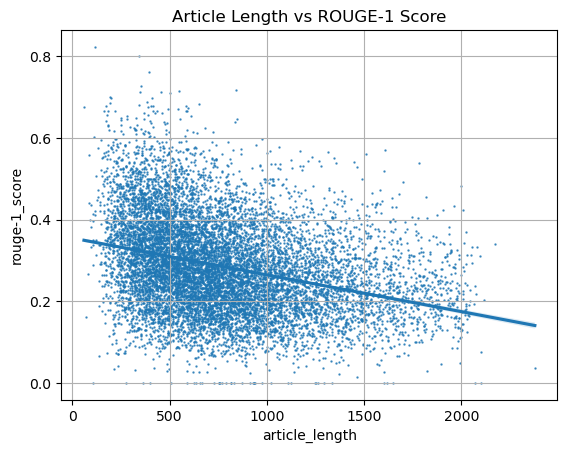

In [85]:
tmp = pd.DataFrame({'article_length': article_len, 'rouge-1_score': rouge1})
sns.regplot(x=tmp['article_length'], y=tmp['rouge-1_score'], scatter_kws={'s': 0.5})
plt.title('Article Length vs ROUGE-1 Score')
plt.grid()
plt.savefig("Figure/TextRank_article_len")

plt.show()

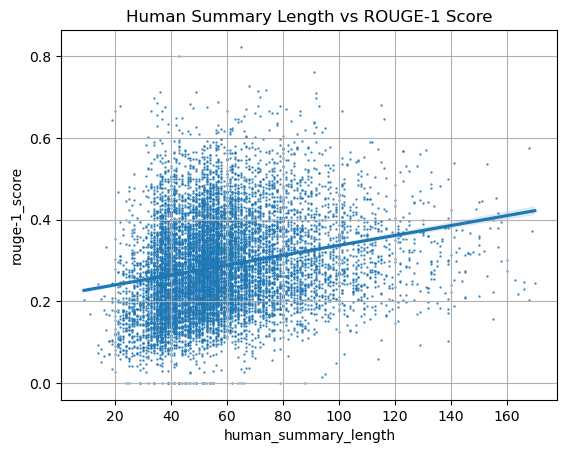

In [86]:
tmp = pd.DataFrame({'human_summary_length': highlight_len, 'rouge-1_score': rouge1})

tmp = tmp[(tmp['human_summary_length'] <= 175)]

sns.regplot(x=tmp['human_summary_length'], y=tmp['rouge-1_score'], scatter_kws={'s': 0.5})
plt.title('Human Summary Length vs ROUGE-1 Score')
plt.grid()
plt.savefig("Figure/TextRank_highlight_len")
plt.show()